In [ ]:
# %%
# Unet.ipynb
# For image segmentation, Image : /home/VirtualFlaw/Dataset_Unet/VF/ACC, Label : /home/VirtualFlaw/Dataset_Unet/VF/REJ
# image size : 512, batch size : 64, learning rate : 0.0001, loss function : Dice Loss
# Use Tensorflow
#
# Path: VirtualFlaw/Dataset_Unet/Unet.ipynb

# %%
import tensorflow as tf
import os
import random
import numpy as np
import cv2

from tqdm import tqdm 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

In [37]:
FLAW_TYPE = "CT"

In [40]:
TRAIN_PATH = f'/home/dais01/VF_MASTER/Generated_Flaw/{FLAW_TYPE}/Reject/'
TRAIN_MASK_PATH = f'/home/dais01/VF_MASTER/Generated_Flaw/{FLAW_TYPE}/Diff/'

train_ids = os.listdir(TRAIN_PATH)

print(len(train_ids))
n_images = 5000
train_ids = train_ids[n_images:n_images+n_images]


X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    X[n] = img
    mask_path = TRAIN_MASK_PATH + id_.replace(".png", "_diff.png")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = np.expand_dims(mask, axis=-1)
    y[n] = mask
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)





10079


100%|██████████| 5000/5000 [01:06<00:00, 75.00it/s]


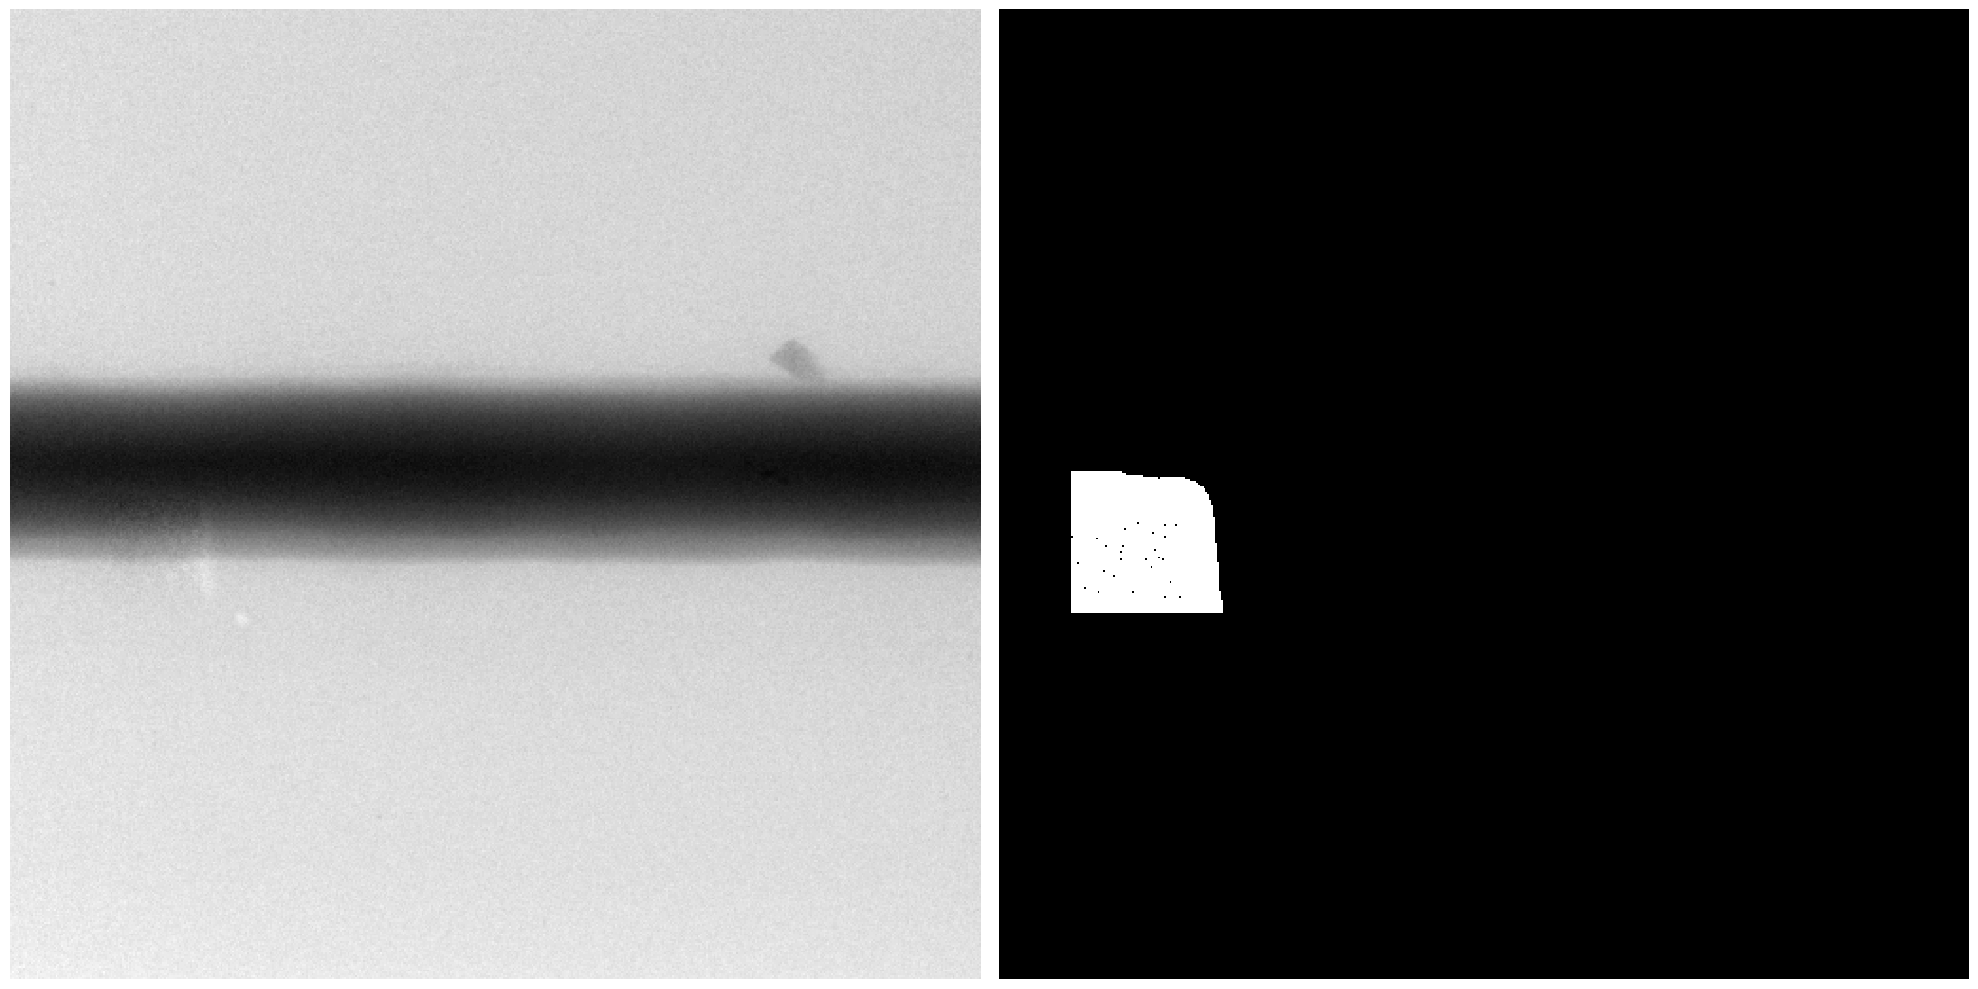

In [41]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
image_x = random.randint(0, len(X_train))
plt.axis("off")
imshow(X_train[image_x])


plt.subplot(1,2,2)
plt.axis("off")
#bool to float
imshow(np.squeeze(y_train[image_x]).astype(float), cmap='gray')


In [ ]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    num_classes = 1
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    b1 = tf.keras.layers.BatchNormalization()(c1)
    r1 = tf.keras.layers.ReLU()(b1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)
    
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    b2 = tf.keras.layers.BatchNormalization()(c2)
    r2 = tf.keras.layers.ReLU()(b2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
    
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    b3 = tf.keras.layers.BatchNormalization()(c3)
    r3 = tf.keras.layers.ReLU()(b3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
    
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    b4 = tf.keras.layers.BatchNormalization()(c4)
    r4 = tf.keras.layers.ReLU()(b4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
    
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    b5 = tf.keras.layers.BatchNormalization()(c5)
    r5 = tf.keras.layers.ReLU()(b5)
    c5 = tf.keras.layers.Dropout(0.3)(r5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.BatchNormalization()(u6)
    u6 = tf.keras.layers.ReLU()(u6)

    
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.BatchNormalization()(u7)
    u7 = tf.keras.layers.ReLU()(u7)

    
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.BatchNormalization()(u8)
    u8 = tf.keras.layers.ReLU()(u8)
    
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    u9 = tf.keras.layers.BatchNormalization()(u9)
    u9 = tf.keras.layers.ReLU()(u9)

    
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)
    lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=0.0001, first_decay_steps=150, t_mul=2, m_mul=0.9, alpha=0.0, name=None)
    checkpoint = ModelCheckpoint(f'/home/dais01/VF_MASTER/models/unet_{FLAW_TYPE}.h5', monitor='val_loss', save_best_only=True, mode="auto")
    early_stop = EarlyStopping(monitor='val_loss', patience=8, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.99, patience=4, mode='min', min_lr=1e-6)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='binary_focal_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.TruePositives()])


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=16, epochs=50, callbacks=[checkpoint, early_stop, reduce_lr])

In [38]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=0.0001, first_decay_steps=150, t_mul=2, m_mul=0.9, alpha=0.0, name=None)
    checkpoint = ModelCheckpoint(f'/home/dais01/VF_MASTER/models/unet_{FLAW_TYPE}.h5', monitor='val_loss', save_best_only=True, mode="auto")
    early_stop = EarlyStopping(monitor='val_loss', patience=8, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.99, patience=4, mode='min', min_lr=1e-6)
    model = tf.keras.models.load_model(f'/home/dais01/VF_MASTER/models/unet_{FLAW_TYPE}.h5')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='binary_focal_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.TruePositives()])

    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [ ]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')

plt.legend()
plt.show()

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']
  plt.figure(figsize=(30, 10))
  for i in range(len(display_list)):
    
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
    
  plt.show()

i = random.randint(0, len(X_test))
sample_image = X_test[i]
sample_mask = y_test[i]
prediction = model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])

In [39]:
TEST_PATH = '/home/dais01/VF_MASTER/Unet Test/Reject/'
test_ids = os.listdir(TEST_PATH)
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
image_name = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    test_images[n] = img
    image_name.append(id_)
os.makedirs(f'/home/dais01/VF_MASTER/Data/Test/{FLAW_TYPE}/', exist_ok=True)
for i in range(len(test_images)):
    prediction = model.predict(test_images[i][tf.newaxis, ...])[0]
    predicted_mask = (prediction > 0.05).astype(np.uint8)
    #3채널로 변경
    predicted_mask = np.concatenate((predicted_mask, predicted_mask, predicted_mask), axis=2)
    predicted_mask = cv2.normalize(predicted_mask, None, 0, 255, cv2.NORM_MINMAX)
    original_image = test_images[i]
    concat_image = np.concatenate((original_image, predicted_mask), axis=1)
    cv2.imwrite(f'/home/dais01/VF_MASTER/Data/Test/{FLAW_TYPE}/'+image_name[i], concat_image)


100%|██████████| 274/274 [00:03<00:00, 74.22it/s]
2023-05-25 12:34:35.490417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:35.490662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:34:36.831917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:36.832151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:37.061547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 185ms/step


2023-05-25 12:34:37.335502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:37.335772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:37.594755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 187ms/step


2023-05-25 12:34:37.876843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:37.877111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 171ms/step


2023-05-25 12:34:38.139818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:38.140077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 161ms/step


2023-05-25 12:34:38.376437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:38.376657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 180ms/step


2023-05-25 12:34:38.611254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:38.611525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 165ms/step


2023-05-25 12:34:38.855875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:38.856095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 186ms/step


2023-05-25 12:34:39.094948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:39.095211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:39.356686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 162ms/step


2023-05-25 12:34:39.621464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:39.621688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 160ms/step


2023-05-25 12:34:39.847396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:39.847641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:34:40.071084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:40.071315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 190ms/step


2023-05-25 12:34:40.298083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:40.298312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:40.563876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 197ms/step


2023-05-25 12:34:40.842105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:40.842381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 197ms/step


2023-05-25 12:34:41.118372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:41.118675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 172ms/step


2023-05-25 12:34:41.398125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:41.398377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 175ms/step


2023-05-25 12:34:41.635710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:41.635959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 191ms/step


2023-05-25 12:34:41.889321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:41.889588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:42.146180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 160ms/step


2023-05-25 12:34:42.409394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:42.409623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 181ms/step


2023-05-25 12:34:42.644081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:42.644346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 172ms/step


2023-05-25 12:34:42.899420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:42.899695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:43.152819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 163ms/step


2023-05-25 12:34:43.420822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:43.421055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 166ms/step


2023-05-25 12:34:43.652330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:43.652555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:43.883272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 180ms/step


2023-05-25 12:34:44.156510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:44.156776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 168ms/step


2023-05-25 12:34:44.402734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:44.402959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:44.637060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 211ms/step


2023-05-25 12:34:44.922948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:44.923226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:34:45.185158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:45.185381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:34:45.411334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:45.411573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:34:45.639984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:45.640204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:45.876287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 197ms/step


2023-05-25 12:34:46.149312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:46.149578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 167ms/step


2023-05-25 12:34:46.413229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:46.413456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 178ms/step


2023-05-25 12:34:46.656585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:46.656856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 181ms/step


2023-05-25 12:34:46.913400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:46.913668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 185ms/step


2023-05-25 12:34:47.171670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:47.171942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 160ms/step


2023-05-25 12:34:47.422189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:47.422411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 164ms/step


2023-05-25 12:34:47.648681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:47.648916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 185ms/step


2023-05-25 12:34:47.887569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:47.887830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:34:48.136311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:48.136530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:48.372074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 1s 761ms/step


2023-05-25 12:34:49.213984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:49.214323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 203ms/step


2023-05-25 12:34:49.503684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:49.504012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 202ms/step


2023-05-25 12:34:49.789573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:49.789899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 184ms/step


2023-05-25 12:34:50.072102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:50.072419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 184ms/step


2023-05-25 12:34:50.337256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:50.337569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 171ms/step


2023-05-25 12:34:50.591421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:50.591705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 184ms/step


2023-05-25 12:34:50.841097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:50.841406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 175ms/step


2023-05-25 12:34:51.103000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:51.103291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 186ms/step


2023-05-25 12:34:51.355741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:51.356021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 168ms/step


2023-05-25 12:34:51.607917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:51.608145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:51.851574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 170ms/step


2023-05-25 12:34:52.114352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:52.114597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:52.364865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 167ms/step


2023-05-25 12:34:52.629266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:52.629488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:52.890311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 211ms/step


2023-05-25 12:34:53.179858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:53.180128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 164ms/step


2023-05-25 12:34:53.440356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:53.440580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 178ms/step


2023-05-25 12:34:53.679426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:53.679704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:34:53.924264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:53.924486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:34:54.153367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:54.153591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:34:54.377781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:54.378008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:54.615630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 186ms/step


2023-05-25 12:34:54.887959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:54.888226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:34:55.140157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:55.140380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 188ms/step


2023-05-25 12:34:55.381369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:55.381634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 160ms/step


2023-05-25 12:34:55.634476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:55.634709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:34:55.858798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:55.859022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:56.096047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 163ms/step


2023-05-25 12:34:56.358571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:56.358795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 168ms/step


2023-05-25 12:34:56.587409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:56.587658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 164ms/step


2023-05-25 12:34:56.821339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:56.821579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:34:57.051258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:57.051518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:34:57.278182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:57.278406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 178ms/step


2023-05-25 12:34:57.515808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:57.516072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:57.768983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 167ms/step


2023-05-25 12:34:58.055199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:58.055478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 159ms/step


2023-05-25 12:34:58.285144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:58.285366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 174ms/step


2023-05-25 12:34:58.518875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:58.519138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:58.757333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 162ms/step


2023-05-25 12:34:59.024140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:59.024362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:34:59.247418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:59.247659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 160ms/step


2023-05-25 12:34:59.472315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:59.472533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:59.711563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 189ms/step


2023-05-25 12:34:59.976584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:34:59.976829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:00.239850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 215ms/step


2023-05-25 12:35:00.530649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:00.530922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 169ms/step


2023-05-25 12:35:00.797668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:00.797918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:01.041947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 160ms/step


2023-05-25 12:35:01.305713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:01.305934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 192ms/step


2023-05-25 12:35:01.539407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:01.539681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - ETA: 0s

2023-05-25 12:35:01.808894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:01.809163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 160ms/step


2023-05-25 12:35:02.066408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:02.066638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:02.302704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 164ms/step


2023-05-25 12:35:02.567779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:02.567996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:02.809484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 160ms/step


2023-05-25 12:35:03.082884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:03.083104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:35:03.306736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:03.306957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 191ms/step


2023-05-25 12:35:03.545353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:03.545620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 161ms/step


2023-05-25 12:35:03.800327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:03.800548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:35:04.026018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:04.026250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 182ms/step


2023-05-25 12:35:04.262723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:04.262985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 161ms/step


2023-05-25 12:35:04.510921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:04.511144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 189ms/step


2023-05-25 12:35:04.750116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:04.750380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - ETA: 0s

2023-05-25 12:35:05.019880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:05.020153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:35:05.278268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:05.278496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 185ms/step


2023-05-25 12:35:05.514491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:05.514753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:05.765275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 160ms/step


2023-05-25 12:35:06.030424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:06.030645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 182ms/step


2023-05-25 12:35:06.265896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:06.266158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 164ms/step


2023-05-25 12:35:06.514252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:06.514473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 160ms/step


2023-05-25 12:35:06.743272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:06.743518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 160ms/step


2023-05-25 12:35:06.969237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:06.969459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 186ms/step


2023-05-25 12:35:07.214269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:07.214545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 178ms/step


2023-05-25 12:35:07.475660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:07.475929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:07.727292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 188ms/step


2023-05-25 12:35:08.002157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:08.002431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:35:08.254983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:08.255211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 176ms/step


2023-05-25 12:35:08.491701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:08.492017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:35:08.732082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:08.732355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 166ms/step


2023-05-25 12:35:08.961177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:08.961454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:09.202024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 204ms/step


2023-05-25 12:35:09.487748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:09.488025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 171ms/step


2023-05-25 12:35:09.780746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:09.780990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 173ms/step


2023-05-25 12:35:10.018077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:10.018332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 172ms/step


2023-05-25 12:35:10.257448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:10.257699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 171ms/step


2023-05-25 12:35:10.496158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:10.496405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 174ms/step


2023-05-25 12:35:10.734557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:10.734813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 183ms/step


2023-05-25 12:35:10.983803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:10.984067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:35:11.234069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:11.234292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 171ms/step


2023-05-25 12:35:11.471772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:11.472034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - ETA: 0s

2023-05-25 12:35:11.719693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:11.719961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 175ms/step


2023-05-25 12:35:11.991069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:11.991332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:35:12.229725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:12.229947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:12.456513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 1s 667ms/step


2023-05-25 12:35:13.190584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:13.190896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 229ms/step


2023-05-25 12:35:13.501835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:13.502178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 211ms/step


2023-05-25 12:35:13.794658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:13.794985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 177ms/step


2023-05-25 12:35:14.084612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:14.084912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:14.340420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 233ms/step


2023-05-25 12:35:14.653006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:14.653319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 200ms/step


2023-05-25 12:35:14.934040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:14.934357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 171ms/step


2023-05-25 12:35:15.200623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:15.200905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 182ms/step


2023-05-25 12:35:15.449320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:15.449607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 178ms/step


2023-05-25 12:35:15.708579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:15.708846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 166ms/step


2023-05-25 12:35:15.950864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:15.951094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 174ms/step


2023-05-25 12:35:16.192223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:16.192490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 166ms/step


2023-05-25 12:35:16.432534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:16.432768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 165ms/step


2023-05-25 12:35:16.663811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:16.664034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 167ms/step


2023-05-25 12:35:16.892859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:16.893086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - ETA: 0s

2023-05-25 12:35:17.137434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:17.137719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 164ms/step


2023-05-25 12:35:17.396442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:17.396664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 165ms/step


2023-05-25 12:35:17.624882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:17.625114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:17.865857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 163ms/step


2023-05-25 12:35:18.126365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:18.126589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:35:18.354246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:18.354471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:35:18.583937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:18.584159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 180ms/step


2023-05-25 12:35:18.820553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:18.820839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 181ms/step


2023-05-25 12:35:19.078436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:19.078701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:35:19.324566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:19.324802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:35:19.551805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:19.552024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:19.789856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 187ms/step


2023-05-25 12:35:20.081951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:20.082225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 164ms/step


2023-05-25 12:35:20.336432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:20.336655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 165ms/step


2023-05-25 12:35:20.563865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:20.564086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 187ms/step


2023-05-25 12:35:20.793661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:20.793887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 184ms/step


2023-05-25 12:35:21.055875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:21.056146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 168ms/step


2023-05-25 12:35:21.316846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:21.317111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 159ms/step


2023-05-25 12:35:21.552088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:21.552308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 180ms/step


2023-05-25 12:35:21.786504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:21.786766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:35:22.032344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:22.032562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - ETA: 0s

2023-05-25 12:35:22.273206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:22.273519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 191ms/step


2023-05-25 12:35:22.529974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:22.530195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 191ms/step


2023-05-25 12:35:22.803138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:22.803409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:35:23.059883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:23.060102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 164ms/step


2023-05-25 12:35:23.289300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:23.289524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:23.527471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 164ms/step


2023-05-25 12:35:23.793121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:23.793345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:35:24.020049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:24.020269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:24.255004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 169ms/step


2023-05-25 12:35:24.534939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:24.535204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 159ms/step


2023-05-25 12:35:24.769134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:24.769353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 161ms/step


2023-05-25 12:35:24.989848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:24.990069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 168ms/step


2023-05-25 12:35:25.215346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:25.215572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 159ms/step


2023-05-25 12:35:25.447358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:25.447617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 185ms/step


2023-05-25 12:35:25.682918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:25.683224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 187ms/step


2023-05-25 12:35:25.948385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:25.948646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 161ms/step


2023-05-25 12:35:26.200237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:26.200454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:26.436610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 183ms/step


2023-05-25 12:35:26.717407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:26.717676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 172ms/step


2023-05-25 12:35:26.976297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:26.976564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 161ms/step


2023-05-25 12:35:27.214620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:27.214851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 160ms/step


2023-05-25 12:35:27.441918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:27.442141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 173ms/step


2023-05-25 12:35:27.677218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:27.677482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:35:27.913922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:27.914151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 174ms/step


2023-05-25 12:35:28.151537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:28.151803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 160ms/step


2023-05-25 12:35:28.389501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:28.389725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 160ms/step


2023-05-25 12:35:28.612473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:28.612691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:28.851355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 170ms/step


2023-05-25 12:35:29.137303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:29.137575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 164ms/step


2023-05-25 12:35:29.381999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:29.382239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:35:29.628783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:29.629014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - ETA: 0s

2023-05-25 12:35:29.857595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:29.857826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 186ms/step


2023-05-25 12:35:30.130813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:30.131081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 159ms/step


2023-05-25 12:35:30.382549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:30.382772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 161ms/step


2023-05-25 12:35:30.606647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:30.606874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:30.841618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 161ms/step


2023-05-25 12:35:31.105001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:31.105225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:31.340936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 163ms/step


2023-05-25 12:35:31.605227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:31.605450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:35:31.832668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:31.832910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:35:32.058902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:32.059126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - ETA: 0s

2023-05-25 12:35:32.301676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:32.301941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 196ms/step


2023-05-25 12:35:32.573691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:32.573962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 197ms/step


2023-05-25 12:35:32.848088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:32.848354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 193ms/step


2023-05-25 12:35:33.114044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:33.114273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:33.383047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 162ms/step


2023-05-25 12:35:33.644853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:33.645122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:35:33.872368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:33.872628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 172ms/step


2023-05-25 12:35:34.107821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:34.108087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 172ms/step


2023-05-25 12:35:34.354871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:34.355135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 160ms/step


2023-05-25 12:35:34.591718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:34.591937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 174ms/step


2023-05-25 12:35:34.827444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:34.827720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 174ms/step


2023-05-25 12:35:35.076681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:35.076947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 170ms/step


2023-05-25 12:35:35.326419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:35.326681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 161ms/step


2023-05-25 12:35:35.563232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:35.563473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 177ms/step


2023-05-25 12:35:35.798758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:35.799019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 182ms/step


2023-05-25 12:35:36.054201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:36.054467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 180ms/step


2023-05-25 12:35:36.852763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:36.853062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 182ms/step


2023-05-25 12:35:37.104782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:37.105079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:37.378018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 179ms/step


2023-05-25 12:35:37.657459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:37.657746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 176ms/step


2023-05-25 12:35:37.906248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:37.906538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 174ms/step


2023-05-25 12:35:38.149599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:38.149870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 176ms/step


2023-05-25 12:35:38.402029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:38.402340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 169ms/step


2023-05-25 12:35:38.644762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:38.645019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 170ms/step


2023-05-25 12:35:38.878957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:38.879207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:39.127722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 188ms/step


2023-05-25 12:35:39.400224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:39.400496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 175ms/step


2023-05-25 12:35:39.653291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:39.653524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:35:39.892816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:39.893047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 165ms/step


2023-05-25 12:35:40.119335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:40.119579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 165ms/step


2023-05-25 12:35:40.349469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:40.349693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:40.590007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 165ms/step


2023-05-25 12:35:40.896017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:40.896241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:35:41.124970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:41.125197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 164ms/step


2023-05-25 12:35:41.354515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:41.354742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 165ms/step


2023-05-25 12:35:41.584079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:41.584312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:41.824236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 203ms/step


2023-05-25 12:35:42.106670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:42.106941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 163ms/step


2023-05-25 12:35:42.364621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:42.364842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 161ms/step


2023-05-25 12:35:42.591993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:42.592213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 160ms/step


2023-05-25 12:35:42.818714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:42.818937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 182ms/step


2023-05-25 12:35:43.054189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:43.054452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 187ms/step


2023-05-25 12:35:43.316781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:43.317050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 161ms/step


2023-05-25 12:35:43.568640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:43.568873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:35:43.792276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:43.792497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 191ms/step


2023-05-25 12:35:44.028158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:44.028420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:44.298493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 191ms/step


2023-05-25 12:35:44.581428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:44.581700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 188ms/step


2023-05-25 12:35:44.852819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:44.853086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 161ms/step


2023-05-25 12:35:45.105828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:45.106057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 181ms/step


2023-05-25 12:35:45.343700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:45.343970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:45.608272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 182ms/step


2023-05-25 12:35:45.899092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:45.899362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 162ms/step


2023-05-25 12:35:46.147652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:46.147873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1,512,512,3]
	 [[{{node Placeholder/_10}}]]
2023-05-25 12:35:46.388336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8

1/1 [==============================] - 0s 209ms/step
